# Word2Vec from Scratch

In this notebook, we will implement **Word2Vec** from scratch, a popular technique for learning distributed word representations. Word2Vec converts words into dense vector embeddings that capture semantic relationships based on the surrounding context in a text corpus. We will focus on both **CBOW** and **Skip-Gram** architecture.

We will walk through the entire process:
- **Preprocessing the corpus** to tokenize, clean, and build a vocabulary.
- **Generating training data** for the model by creating target-context pairs.
- **Initializing and training the model** by updating weights using the CBOW and  Skip-Gram approach.
- **Extracting word embeddings** to visualize the learned word vectors.

## What is Word2Vec?

Word2Vec is a machine learning technique that transforms words into dense vector representations, capturing semantic relationships based on their context in a corpus. It uses two architectures: **Skip-Gram**, which predicts context words given a target word, and **CBOW (Continuous Bag of Words)**, which predicts a target word from surrounding context words. By training on large text data, Word2Vec learns embeddings where words with similar meanings are positioned closer in the vector space, enabling efficient natural language processing tasks like sentiment analysis, clustering, and recommendation systems.

### CBOW (Continuous Bag of Words)
The **Continuous Bag of Words (CBOW)** model is one of the two architectures in Word2Vec. It aims to predict a target word based on the surrounding context words. Here's how it works:
1. **Context Window**: For a given target word, a context window is selected (typically a fixed number of words before and after the target word).
2. **Prediction**: CBOW uses the context words (surrounding words) to predict the target word (center word). The model tries to maximize the probability of the target word, given the context.
   
For example, in the sentence **"The cat sat on the mat,"** if the target word is "sat," the context words would be **["the", "cat", "on", "the", "mat"]**. The model uses these context words to predict the word "sat." 

This approach works well for smaller datasets and is efficient when the task involves predicting target words based on context.

### Skip-Gram Model
The **Skip-Gram** model is the second architecture in Word2Vec. Unlike CBOW, Skip-Gram tries to predict the context words based on a given target word. Instead of predicting a single target word from context, Skip-Gram focuses on maximizing the probability of context words given the target word. 

For example, using the same sentence **"The cat sat on the mat,"** if "sat" is the target word, the model tries to predict context words **["the", "cat", "on", "the", "mat"]**. 

Skip-Gram is more effective in cases where we have large corpora and is particularly good at handling rare words by using context.

### Key Differences Between CBOW and Skip-Gram
- **CBOW** uses context words to predict the target word, making it faster for training and better for smaller datasets.
- **Skip-Gram** predicts the context words based on the target word, which is more effective for large datasets and rare words.
- **Training Efficiency**: CBOW is faster due to fewer weight updates as it predicts one word from the context, while Skip-Gram requires updating weights for multiple context words per target word.

Both architectures aim to generate vector embeddings where words with similar meanings are placed closer in the vector space, and can be applied to a wide range of tasks like sentiment analysis, machine translation, and word similarity analysis.

---

In the upcoming sections of this notebook, we will implement both CBOW and Skip-Gram models from scratch, starting with preprocessing the dataset and building the vocabulary.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
from collections import Counter
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder

In [3]:
corpus = [
    "The sky is blue and beautiful",
    "Love this blue and beautiful sky",
    "The quick brown fox jumps over the lazy dog",
    "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans",
    "I love green eggs, ham, sausages, and bacon",
    "The brown fox is quick and the blue dog is lazy",
    "The sky is very blue and the sky is very beautiful today",   
]


## Text preprocessing

In [4]:
stemmer=PorterStemmer()
def text_cleaning(corpus):
    cleaned_corpus=[]
    for review in corpus:
        review=re.sub('[^a-zA-Z]',' ',review)
        review=review.lower().split()
        review=[stemmer.stem(word) for word in review if word not in stopwords.words('english')]
        review=' '.join (review)
        cleaned_corpus.append(review)
    return cleaned_corpus  

In [5]:
corpus=text_cleaning(corpus)
corpus

['sky blue beauti',
 'love blue beauti sky',
 'quick brown fox jump lazi dog',
 'king breakfast sausag ham bacon egg toast bean',
 'love green egg ham sausag bacon',
 'brown fox quick blue dog lazi',
 'sky blue sky beauti today']

In [6]:
tokenized_corpus = [sentence.split() for sentence in corpus]
tokenized_corpus

[['sky', 'blue', 'beauti'],
 ['love', 'blue', 'beauti', 'sky'],
 ['quick', 'brown', 'fox', 'jump', 'lazi', 'dog'],
 ['king', 'breakfast', 'sausag', 'ham', 'bacon', 'egg', 'toast', 'bean'],
 ['love', 'green', 'egg', 'ham', 'sausag', 'bacon'],
 ['brown', 'fox', 'quick', 'blue', 'dog', 'lazi'],
 ['sky', 'blue', 'sky', 'beauti', 'today']]

In [7]:
for sentence in tokenized_corpus:
    for word in sentence:
        print (word)

sky
blue
beauti
love
blue
beauti
sky
quick
brown
fox
jump
lazi
dog
king
breakfast
sausag
ham
bacon
egg
toast
bean
love
green
egg
ham
sausag
bacon
brown
fox
quick
blue
dog
lazi
sky
blue
sky
beauti
today


## Building vocabulary

In [8]:
def build_vocab(corpus):
    # Flatten the corpus into one list and count the frequency of words
    words = [word for sentence in corpus for word in sentence]
    word_counts = Counter(words)
    vocabulary = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
    return vocabulary, word_counts

In [9]:
vocabulary, word_counts = build_vocab(tokenized_corpus)

In [10]:
word_counts

Counter({'sky': 4,
         'blue': 4,
         'beauti': 3,
         'love': 2,
         'quick': 2,
         'brown': 2,
         'fox': 2,
         'jump': 1,
         'lazi': 2,
         'dog': 2,
         'king': 1,
         'breakfast': 1,
         'sausag': 2,
         'ham': 2,
         'bacon': 2,
         'egg': 2,
         'toast': 1,
         'bean': 1,
         'green': 1,
         'today': 1})

In [11]:
vocabulary

{'sky': 0,
 'blue': 1,
 'beauti': 2,
 'love': 3,
 'quick': 4,
 'brown': 5,
 'fox': 6,
 'jump': 7,
 'lazi': 8,
 'dog': 9,
 'king': 10,
 'breakfast': 11,
 'sausag': 12,
 'ham': 13,
 'bacon': 14,
 'egg': 15,
 'toast': 16,
 'bean': 17,
 'green': 18,
 'today': 19}

In [12]:
vocab_size=len(vocabulary)
vocab_size

20

### Defining context_window and Embedding_dim

In [13]:
context_window = 2  # Number of words around the target word
embedding_dim = 5  # Dimensionality of the word embeddings

### One Hot Encoding

In [14]:
encoder=OneHotEncoder(sparse=False)
encoded_vocab=encoder.fit_transform(np.array(list(vocabulary.values())).reshape(-1,1))
encoded_vocab

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [15]:
 for sentence in tokenized_corpus:
        for idx,target_word in enumerate(sentence):
            print(idx,target_word)

0 sky
1 blue
2 beauti
0 love
1 blue
2 beauti
3 sky
0 quick
1 brown
2 fox
3 jump
4 lazi
5 dog
0 king
1 breakfast
2 sausag
3 ham
4 bacon
5 egg
6 toast
7 bean
0 love
1 green
2 egg
3 ham
4 sausag
5 bacon
0 brown
1 fox
2 quick
3 blue
4 dog
5 lazi
0 sky
1 blue
2 sky
3 beauti
4 today


## Generating CBOW data
**Input**: It takes a corpus (list of tokenized sentences) and a context_window (an integer that defines how many words before and after the target word will be considered as context).

**Context-Target Pairing**:

For each word in the sentence (target_word), it selects a context window around it.
The context window is defined by the context_window size, which gives the surrounding words (not including the target word itself).

**Building Context and Target:**

Context: All words in the sentence that fall within the context window around the target word.

Target: The target word itself, converted to its index in the vocabulary.

**Output:** The function appends pairs of context (list of word indices) and target (single word index) to the context_target_pairs list. This list contains all the (context, target) pairs needed for training the CBOW model.

In [16]:
def generate_cbow_data(corpus,contect_window):
    context_target_pairs=[]
    for sentence in corpus:
        for idx,target_word in enumerate(sentence):
            start=max(0, idx-context_window)
            end=min(len(sentence), idx+context_window+1)

            context=[sentence[i] for i in range(start, end) if i !=idx]
            target_idx=vocabulary[target_word]
            context_idx=[vocabulary[word] for word in context]
            context_target_pairs.append((context_idx,target_idx))
    return context_target_pairs
context_target_pairs = generate_cbow_data(tokenized_corpus, context_window)
context_target_pairs

[([1, 2], 0),
 ([0, 2], 1),
 ([0, 1], 2),
 ([1, 2], 3),
 ([3, 2, 0], 1),
 ([3, 1, 0], 2),
 ([1, 2], 0),
 ([5, 6], 4),
 ([4, 6, 7], 5),
 ([4, 5, 7, 8], 6),
 ([5, 6, 8, 9], 7),
 ([6, 7, 9], 8),
 ([7, 8], 9),
 ([11, 12], 10),
 ([10, 12, 13], 11),
 ([10, 11, 13, 14], 12),
 ([11, 12, 14, 15], 13),
 ([12, 13, 15, 16], 14),
 ([13, 14, 16, 17], 15),
 ([14, 15, 17], 16),
 ([15, 16], 17),
 ([18, 15], 3),
 ([3, 15, 13], 18),
 ([3, 18, 13, 12], 15),
 ([18, 15, 12, 14], 13),
 ([15, 13, 14], 12),
 ([13, 12], 14),
 ([6, 4], 5),
 ([5, 4, 1], 6),
 ([5, 6, 1, 9], 4),
 ([6, 4, 9, 8], 1),
 ([4, 1, 8], 9),
 ([1, 9], 8),
 ([1, 0], 0),
 ([0, 0, 2], 1),
 ([0, 1, 2, 19], 0),
 ([1, 0, 19], 2),
 ([0, 2], 19)]

In [17]:
def generate_cbow_data_inwords(corpus, context_window):
    context_target_pairs = []
    # Reverse the vocabulary dictionary to map index to word
    index_to_word = {index: word for word, index in vocabulary.items()}
    
    for sentence in corpus:
        for idx, target_word in enumerate(sentence):
            start = max(0, idx - context_window)
            end = min(len(sentence), idx + context_window + 1)

            context = [sentence[i] for i in range(start, end) if i != idx]
            
            # Get the words instead of indices
            target_word_in_vocab = target_word  # Target word remains the same
            context_words = [sentence[i] for i in range(start, end) if i != idx]

            # Append the word-context pairs
            context_target_pairs.append((context_words, target_word_in_vocab))

    return context_target_pairs
context_target_pairs_inwords = generate_cbow_data_inwords(tokenized_corpus, context_window)
len(context_target_pairs_inwords)

38

In [18]:
def initialize_weights(vocab_size,embedding_dim):
    W_in = np.random.uniform(-1,1,(vocab_size,embedding_dim))  # Initialize input weights (context to hidden layer)
    # Initialize output weights (hidden to output layer)
    W_out = np.random.uniform(-1, 1, (embedding_dim, vocab_size))
    return W_in, W_out
W_in, W_out = initialize_weights(vocab_size, embedding_dim)
W_out.shape

(5, 20)

# Training CBOW Model

## 1. Function Definition
The `train_cbow` function trains a CBOW model using:
- **Inputs**:
  - `corpus`: Tokenized sentences.
  - `context_target_pairs`: Pairs of context words and target words.
  - `W_in`: Input weight matrix (`vocab_size × embedding_dim`) storing word embeddings.
  - `W_out`: Output weight matrix (`embedding_dim × vocab_size`) mapping context to word probabilities.
- **Hyperparameters**: Number of training epochs and learning rate.

---

## 2. Forward Pass
### Context Vector Calculation
- The context embeddings (`n × embedding_dim`) are averaged to form a context vector (`embedding_dim`).

### Prediction
- Multiply the context vector (`embedding_dim`) with `W_out` (`embedding_dim × vocab_size`) to get a predicted vector (`vocab_size`).

### Softmax
- Transform the predicted vector (`vocab_size`) into a probability distribution over the vocabulary.

---

## 3. Loss Calculation
### Target Vector
- Represent the target word as a one-hot vector of size `vocab_size`.

### Cross-Entropy Loss
- Compute the loss based on the difference between the predicted probabilities and the target word.

---

## 4. Backpropagation
### Error Calculation
- Calculate the error (`vocab_size`) by subtracting the target vector from the predicted probabilities.

### Gradients
- **Output Weights (`W_out`)**:
  - Calculate the gradient as the outer product of the context vector (`embedding_dim`) and the error (`vocab_size`), resulting in `embedding_dim × vocab_size`.
- **Input Weights (`W_in`)**:
  - Compute the gradient by multiplying the error (`vocab_size`) with the transpose of `W_out` (`vocab_size × embedding_dim`), then averaging over `n` context words to get `embedding_dim`.

---

## 5. Weight Updates
### Input Weights
- Update `W_in` (`vocab_size × embedding_dim`) for the context words using the computed gradient.

### Output Weights
- Update `W_out` (`embedding_dim × vocab_size`) using the gradient.

---

## 6. Training Loop
1. Iterate over all context-target pairs for a specified number of epochs.
2. For each pair:
   - Compute the context vector via forward pass.
   - Calculate the loss and gradients during backpropagation.
   - Update `W_in` and `W_out` using gradient descent.
3. Monitor the total loss in each epoch.

This process gradually improves the CBOW model's accuracy in predicting target words based on context, leveraging the specified dimensionality at each step.


In [19]:
def train_cbow(corpus, context_target_pairs,W_in,W_out,epochs=200,learning_rate=0.05):
    for epoch in range(epochs):
        total_loss=0
        for context_words,target_word in context_target_pairs:
            context_vectors=np.mean(W_in[context_words],axis=0)
            predicted_word_vector=np.dot(context_vectors,W_out)
            # Compute the softmax function for output layer
            exp_scores=np.exp(predicted_word_vector)
            probs=exp_scores/np.sum(exp_scores)
            # Compute loss
            target_vector=np.zeros(vocab_size)
            target_vector[target_word]=1
            loss= -np.log(probs[target_word])
            total_loss +=loss
            # Backpropogation
            error=probs -target_vector
            dW_out= np.outer(context_vectors,error)
            dW_in = np.dot(error, W_out.T) / len(context_words)  # Corrected gradient
            # Update Weights
            W_in[context_words]-= learning_rate * dW_in
            W_out -= learning_rate* dW_out
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss}")

# Train the CBOW model
train_cbow(tokenized_corpus, context_target_pairs, W_in, W_out, epochs=100, learning_rate=0.01)

# Extract learned word embeddings
word_embeddings = W_in
print("Learned word embeddings:")
print(word_embeddings)

Epoch 100/100, Loss: 79.2711628373601
Learned word embeddings:
[[ 0.40394698  0.88989258 -0.42751692  1.0256363  -0.06924945]
 [-0.80373126 -1.06444385 -1.35340571  0.19909426 -0.48880177]
 [ 0.6646019   0.78376181 -1.28518831  1.66796791 -1.83232218]
 [-0.06437031 -0.23090302  0.28971104  0.36837557 -0.5228859 ]
 [-0.21004882 -0.91912548  0.47133181 -1.04593952 -0.02356047]
 [ 0.71895253 -0.33732462 -0.2626853  -1.6141949  -0.53456578]
 [-0.27474811  0.66289308  1.46105585 -0.80324168  0.71832287]
 [ 0.15444811 -0.14346614 -0.172134   -1.06294692  0.19089646]
 [-0.03369956  0.14686472  0.32606167 -0.01400756  0.4199413 ]
 [ 0.546881    0.69181146  0.77615928 -0.51812945  0.93651702]
 [-0.89251842 -1.01212627 -0.21842565 -0.44978958  0.57626747]
 [ 1.23668219 -0.45141259  0.40360277 -0.51597284  0.62215122]
 [ 0.84111284 -0.64577018 -0.32425686  0.0996066  -0.2621909 ]
 [-0.34881044 -1.40322261 -0.55419585  0.41730529  0.93992779]
 [-0.58053829 -0.68723164 -0.17385116  0.00508472  0.96

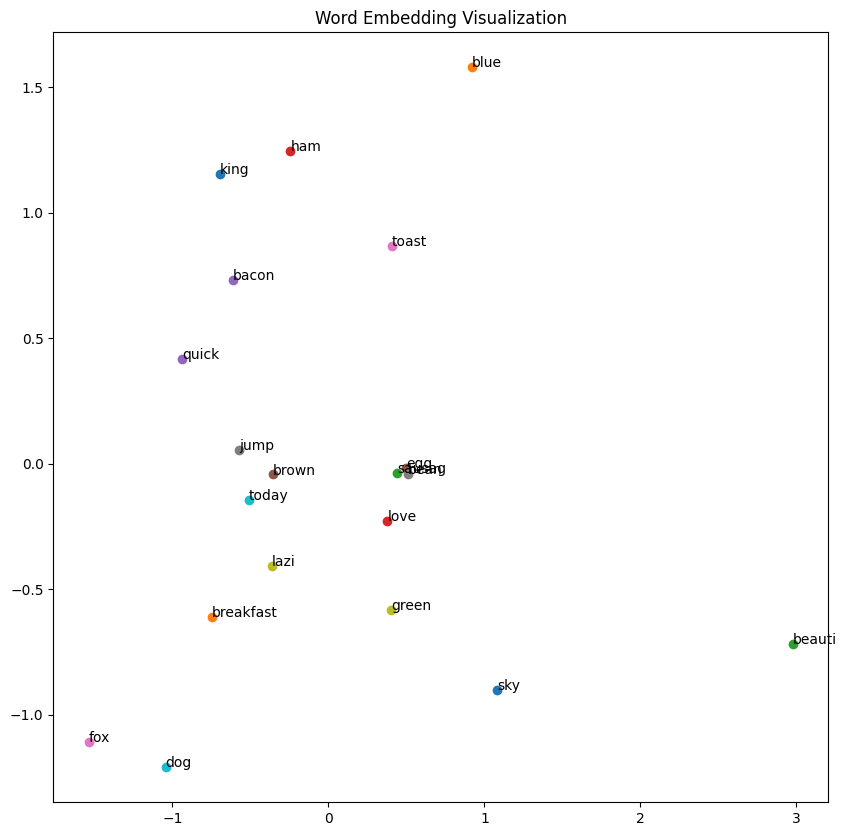

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(W_in)

# Plot the embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(vocabulary):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("Word Embedding Visualization")
plt.show()


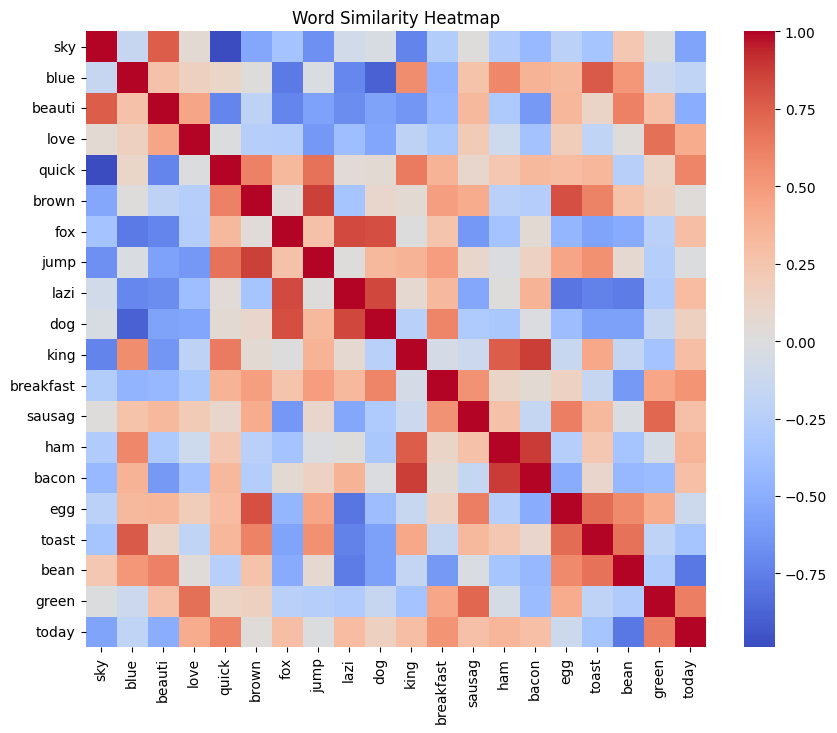

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(W_in)

# Create a heatmap of word similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=vocabulary.keys(), yticklabels=vocabulary.keys(), cmap="coolwarm")
plt.title("Word Similarity Heatmap")
plt.show()
